In [1]:
import os
import numpy as np

from tianshou.policy import DDPGPolicy
from tianshou.utils.net.common import Net
from tianshou.exploration import GaussianNoise
from tianshou.trainer import offpolicy_trainer
from tianshou.utils.net.continuous import Actor, Critic
from tianshou.data import Collector, ReplayBuffer, VectorReplayBuffer, to_numpy
import torch
import datetime
import pickle
import matplotlib.pyplot as plt



In [2]:
from CF_env import CFEnv

env = CFEnv('liming')
train_envs = CFEnv('liming')
test_envs = CFEnv('liming')


state_shape = env.observation_space.shape 
action_shape = env.action_space.shape
print("Observations shape:", state_shape)
print("Actions shape:", action_shape)
print(env.rewardName)

Observations shape: (3,)
Actions shape: (1,)
liming


In [3]:

resume_path = None

seed = 1
actor_lr = 1e-4
critic_lr = 1e-3
tau = .001
gamma = .99
exploration_noise = .15
buffer_size = 100000
batch_size = 256

# seed
np.random.seed(seed)
torch.manual_seed(seed)
train_envs.seed(seed)
test_envs.seed(seed)

# model
net_a = Net(state_shape, hidden_sizes=[256, 256], device='cuda')
actor = Actor(net_a, action_shape, device='cuda').to('cuda')
actor_optim = torch.optim.Adam(actor.parameters(), lr=actor_lr)

net_c = Net(state_shape, action_shape,
            hidden_sizes=[256, 256],
            concat=True, device='cuda')
critic = Critic(net_c, device='cuda').to('cuda')
critic_optim = torch.optim.Adam(critic.parameters(), lr=critic_lr)

policy = DDPGPolicy(
    actor, actor_optim, critic, critic_optim,
    tau=tau, gamma=gamma,
    exploration_noise=GaussianNoise(sigma=exploration_noise),
    estimation_step=1, action_space=action_shape)

# load a previous policy
if resume_path:
    policy.load_state_dict(torch.load(resume_path, map_location='cuda'))
    print("Loaded agent from: ", resume_path)

# collector

buffer = ReplayBuffer(buffer_size)
train_collector = Collector(policy, train_envs, buffer, exploration_noise=True)
test_collector = Collector(policy, test_envs)
train_collector.collect(n_step=buffer_size // 4, random=True)

# log
t0 = datetime.datetime.now().strftime("%m%d_%H%M%S")
log_file = f'seed_{seed}_{t0}_ddpg'
log_path = os.path.join('log', 'ddpg')

def save_fn(policy):
    torch.save(policy.state_dict(), os.path.join(log_path, log_file + '_policy.pth'))
    
# trainer
result = offpolicy_trainer(
    policy, train_collector, test_collector, max_epoch=15,
    step_per_epoch=10000, step_per_collect=1, episode_per_test= 1,
    batch_size=batch_size, save_fn=save_fn,
    update_per_step=1, test_in_train=False)

# Let's watch its performance!
# print('\n start testing')
# policy.eval()
# test_envs.seed(seed)
# test_collector.reset()
# result = test_collector.collect(n_episode=1)
# print(f'Final reward: {result["rews"].mean()}, length: {result["lens"].mean()}')

#save policy
# torch.save(policy.state_dict(), os.path.join(log_path, log_file + '_policy.pth'))

Epoch #1: 10001it [02:37, 63.37it/s, env_step=10000, len=1614, loss/actor=-229.923, loss/critic=63.642, n/ep=0, n/st=1, rew=40632.07]
Epoch #2:   0%| | 12/10000 [00:00<01:53, 88.20it/s, env_step=10012, len=1614, loss/actor=-230.024, loss/critic=66.261, 

Epoch #1: test_reward: 40891.589844 ± 0.000000, best_reward: 40891.589844 ± 0.000000 in #1


Epoch #2: 10001it [02:38, 63.16it/s, env_step=20000, len=1614, loss/actor=-420.376, loss/critic=128.441, n/ep=0, n/st=1, rew=42468.16]
Epoch #3:   0%| | 8/10000 [00:00<02:54, 57.30it/s, env_step=20008, len=1614, loss/actor=-420.518, loss/critic=130.752, 

Epoch #2: test_reward: 42263.136719 ± 0.000000, best_reward: 42263.136719 ± 0.000000 in #2


Epoch #3: 10001it [02:36, 64.01it/s, env_step=30000, len=1614, loss/actor=-616.148, loss/critic=202.294, n/ep=0, n/st=1, rew=43379.03]
Epoch #4:   0%| | 13/10000 [00:00<01:57, 85.13it/s, env_step=30013, len=1614, loss/actor=-617.315, loss/critic=234.140,

Epoch #3: test_reward: 44054.273438 ± 0.000000, best_reward: 44054.273438 ± 0.000000 in #3


Epoch #4: 10001it [02:34, 64.93it/s, env_step=40000, len=1614, loss/actor=-804.012, loss/critic=305.962, n/ep=0, n/st=1, rew=44372.80]
Epoch #5:   0%| | 11/10000 [00:00<02:06, 78.97it/s, env_step=40011, len=1614, loss/actor=-804.315, loss/critic=359.564,

Epoch #4: test_reward: 46337.648438 ± 0.000000, best_reward: 46337.648438 ± 0.000000 in #4


Epoch #5: 10001it [02:19, 71.88it/s, env_step=50000, len=1614, loss/actor=-980.072, loss/critic=578.034, n/ep=0, n/st=1, rew=45069.06]
Epoch #6:   0%| | 13/10000 [00:00<01:52, 88.57it/s, env_step=50013, len=1614, loss/actor=-980.833, loss/critic=609.943,

Epoch #5: test_reward: 45442.128906 ± 0.000000, best_reward: 46337.648438 ± 0.000000 in #4


Epoch #6: 10001it [02:19, 71.90it/s, env_step=60000, len=1614, loss/actor=-1147.558, loss/critic=666.832, n/ep=0, n/st=1, rew=45783.32]
Epoch #7:   0%| | 14/10000 [00:00<01:49, 91.13it/s, env_step=60014, len=1614, loss/actor=-1147.238, loss/critic=740.023

Epoch #6: test_reward: 45923.070312 ± 0.000000, best_reward: 46337.648438 ± 0.000000 in #4


Epoch #7: 10001it [02:14, 74.21it/s, env_step=70000, len=1614, loss/actor=-1297.860, loss/critic=1243.384, n/ep=0, n/st=1, rew=45617.04]
Epoch #8:   0%| | 14/10000 [00:00<01:56, 85.99it/s, env_step=70014, len=1614, loss/actor=-1296.487, loss/critic=1162.58

Epoch #7: test_reward: 45793.753906 ± 0.000000, best_reward: 46337.648438 ± 0.000000 in #4


Epoch #8: 10001it [02:17, 72.87it/s, env_step=80000, len=1614, loss/actor=-1441.394, loss/critic=1594.239, n/ep=0, n/st=1, rew=45726.77]
Epoch #9:   0%| | 13/10000 [00:00<01:56, 86.05it/s, env_step=80013, len=1614, loss/actor=-1442.940, loss/critic=1677.39

Epoch #8: test_reward: 45980.355469 ± 0.000000, best_reward: 46337.648438 ± 0.000000 in #4


Epoch #9: 10001it [02:18, 72.15it/s, env_step=90000, len=1614, loss/actor=-1586.963, loss/critic=1846.996, n/ep=0, n/st=1, rew=45723.01]
Epoch #10:   0%| | 12/10000 [00:00<02:08, 77.85it/s, env_step=90012, len=1614, loss/actor=-1586.783, loss/critic=1845.1

Epoch #9: test_reward: 45954.214844 ± 0.000000, best_reward: 46337.648438 ± 0.000000 in #4


Epoch #10: 10001it [02:18, 72.32it/s, env_step=100000, len=1614, loss/actor=-1745.678, loss/critic=1130.187, n/ep=0, n/st=1, rew=45757.05]
Epoch #11:   0%| | 12/10000 [00:00<02:06, 78.99it/s, env_step=100012, len=1614, loss/actor=-1745.609, loss/critic=1258.

Epoch #10: test_reward: 46062.062500 ± 0.000000, best_reward: 46337.648438 ± 0.000000 in #4


Epoch #11: 10001it [02:34, 64.62it/s, env_step=110000, len=1614, loss/actor=-1879.185, loss/critic=2571.417, n/ep=0, n/st=1, rew=45912.95]
Epoch #12:   0%| | 12/10000 [00:00<02:16, 73.16it/s, env_step=110012, len=1614, loss/actor=-1879.532, loss/critic=2385.

Epoch #11: test_reward: 45363.378906 ± 0.000000, best_reward: 46337.648438 ± 0.000000 in #4


Epoch #12: 10001it [02:55, 56.97it/s, env_step=120000, len=1614, loss/actor=-1981.571, loss/critic=3877.673, n/ep=0, n/st=1, rew=44728.08]
Epoch #13:   0%| | 11/10000 [00:00<02:25, 68.56it/s, env_step=120011, len=1614, loss/actor=-1981.974, loss/critic=3566.

Epoch #12: test_reward: 45041.894531 ± 0.000000, best_reward: 46337.648438 ± 0.000000 in #4


Epoch #13: 10001it [02:34, 64.55it/s, env_step=130000, len=1614, loss/actor=-2058.547, loss/critic=3199.442, n/ep=0, n/st=1, rew=44201.76]
Epoch #14:   0%| | 13/10000 [00:00<02:10, 76.39it/s, env_step=130013, len=1614, loss/actor=-2058.826, loss/critic=3029.

Epoch #13: test_reward: 44846.179688 ± 0.000000, best_reward: 46337.648438 ± 0.000000 in #4


Epoch #14: 10001it [03:05, 53.81it/s, env_step=140000, len=846, loss/actor=-2124.714, loss/critic=2874.476, n/ep=0, n/st=1, rew=21008.17]
Epoch #15:   0%| | 11/10000 [00:00<02:23, 69.75it/s, env_step=140011, len=846, loss/actor=-2124.550, loss/critic=2514.1

Epoch #14: test_reward: 44016.648438 ± 0.000000, best_reward: 46337.648438 ± 0.000000 in #4


Epoch #15: 10001it [02:37, 63.62it/s, env_step=150000, len=1614, loss/actor=-2186.550, loss/critic=2842.331, n/ep=0, n/st=1, rew=44000.29]


Epoch #15: test_reward: 44594.160156 ± 0.000000, best_reward: 46337.648438 ± 0.000000 in #4


In [4]:
def get_reward(acceleration, newSpacing, follower_speed, leader_speed):
    newTimeGap = newSpacing / (follower_speed + .001)
    expected_speed = 33.5
    expected_time_gap = 1
    alpha = 1
    beta = 1
    gamma = 1
    delta = 4
    reward = 0
    
    # time headway
    penalty1 = [[0]]
    if expected_time_gap > newTimeGap > 0:
        penalty1 = - alpha * (100 - 100 * np.sqrt(max(0, expected_time_gap-(expected_time_gap-newTimeGap)**2)))
        reward += penalty1

    # speed reward
    reward2 = beta * min(expected_speed, follower_speed)
    reward += reward2

    #speed diff reward
    reward3 = [[0]]
    if newTimeGap < expected_time_gap and leader_speed > follower_speed:
        reward3 = gamma * (leader_speed - follower_speed) * (expected_time_gap - newTimeGap)
        reward += reward3
        
    penalty4 = - delta * acceleration ** 2
    reward += penalty4

    return reward, penalty1, reward2, reward3, penalty4

In [5]:
policy.load_state_dict(torch.load(os.getcwd() + '\\' + os.path.join(log_path, log_file + '_policy.pth'), 
                                  map_location='cuda'))
print("Loaded agent from: ", log_file)
policy.eval()
rewardHist = [[np.nan] * 4]

from CF_env import vehicle
SIM_RESOLUTION = .1
USED_HISTORY_STAMP  = 1
leadSpeedProfile = np.genfromtxt('test_leader.csv', delimiter=',')
leaderLoc = [0]
followerLoc = [-30]
for v in leadSpeedProfile[1:USED_HISTORY_STAMP]:
    leaderLoc.append(leaderLoc[-1] + v * SIM_RESOLUTION)
    followerLoc.append(followerLoc[-1] + v * SIM_RESOLUTION)
follower = vehicle(leadSpeedProfile[:USED_HISTORY_STAMP], followerLoc)
leader = vehicle(leadSpeedProfile[:USED_HISTORY_STAMP], leaderLoc)
followerSpeedProfile = leadSpeedProfile[:USED_HISTORY_STAMP]
followerSpacing = np.array([30] * USED_HISTORY_STAMP)
observation = np.concatenate((leader.speedT, follower.speedT,
                          [leader.locT[i] - follower.locT[i] for i in range(USED_HISTORY_STAMP)]))

t = USED_HISTORY_STAMP
while True:
    with torch.no_grad():  
        obs = np.array([observation])
        result = policy.actor(obs)
    act = to_numpy(result[0])
    action = policy.map_action(act)
    
    follower.action_a(action)
    leader.action_v(leadSpeedProfile[t])
    newSpacing = leader.location - follower.location
    newStates = np.concatenate((leader.speedT, follower.speedT,
                          [leader.locT[i] - follower.locT[i] for i in range(USED_HISTORY_STAMP)]))
    followerSpeedProfile = np.append(followerSpeedProfile, [follower.speed])
    followerSpacing = np.append(followerSpacing, newSpacing)
    reward, penalty1, reward2, reward3, penalty4 = get_reward(action, 
                                                              newSpacing, 
                                                              follower.speed, 
                                                              leader.speed)
    rewardHist.append([i[0][0] for i in [penalty1, reward2, reward3, penalty4]])
    #current obs
    t += 1
    observation = newStates
    if newSpacing < 0 or t >= len(leadSpeedProfile):
        done = 1
    else:
        done = 0
        
    if done:
        break




Loaded agent from:  seed_1_0508_170045_ddpg


ValueError: x and y must have same first dimension, but have shapes (2828,) and (2256,)

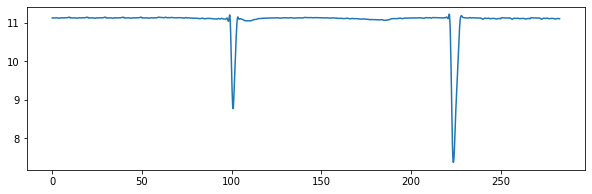

In [6]:

plt.figure(figsize = (10, 3))
plt.plot(np.arange(len(leadSpeedProfile)) / 10, leadSpeedProfile, label = 'leader')
plt.plot(np.arange(len(leadSpeedProfile)) / 10, followerSpeedProfile, label = 'follower')
plt.xlabel('time(s)')
plt.ylabel('speed(m/s)')
# plt.ylim(22.5, 32.5)
plt.grid(True)
plt.legend()
plt.show()

plt.figure(figsize = (10, 3))
plt.plot(np.arange(len(leadSpeedProfile)) / 10, followerSpacing)
plt.xlabel('time(s)')
plt.ylabel('spacing(m)')
plt.grid(True)
# plt.ylim(20, 45)

plt.show()



In [ ]:
print(round(min(followerSpeedProfile[:1000]),2), round(min(followerSpeedProfile[1000:]),2))

In [ ]:
file = open(os.path.join(log_path, log_file + 'trajInfo'), 'wb')
pickle.dump([leadSpeedProfile, followerSpeedProfile, followerSpacing], file)
file.close()